# Supervised Learning: Predicting Depression Severity

This notebook implements three supervised learning models to predict depression severity, measured by the PHQ-9 total score (`PHQ9_TOTAL`). The input dataset, `merged_clean_sl.csv`, contains cleaned binary, ordinal, and continuous variables selected from the 2021–2023 NHANES questionnaire modules.

## Modeling Overview

Three models are trained and evaluated:
- Logistic Regression  
- Random Forest  
- Support Vector Machine (SVM)

All models use a common set of 19 predictors. These include:
- Demographics (e.g., age, household size)
- Socioeconomic factors (e.g., poverty index, education, insurance coverage)
- Health access and behaviors (e.g., usual care source, mental health visits)
- Sleep and self-reported anxiety

Features were selected based on prior clustering results and domain relevance to depression risk. No one-hot encoding is used. Evaluation will use cross-validation with metrics such as accuracy, F1 score, and ROC-AUC (if classification).

The top-performing model will include:
- Feature importance analysis  
- Sensitivity or ablation study  
- Discussion of performance tradeoffs

Failure analysis will identify at least three common prediction errors and explore possible causes.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../data/clean/merged_clean_sl.csv")

# Show the first few rows
df.head()

,Gender,Age in years at screening,Education level - Adults 20+,Total number of people in the Household,Difficulty these problems have caused,Difficulty with self-care,How often feel worried/nervous/anxious,Level of feeling worried/nervous/anxious,Covered by health insurance,Covered by private insurance,...,Covered by state-sponsored health plan,Time when no insurance in past year?,Routine place to go for healthcare,Type place most often go for healthcare,Past 12 months had video conf w/Dr?,Seen mental health professional/past yr,Monthly poverty index,Sleep hours - weekdays or workdays,Sleep hours - weekends,PHQ9_TOTAL
0,1,33,3,3,2,1,1,2,1,0,...,0,0,1,1,0,0,0.94,7.5,7.5,24.0
1,1,67,3,2,0,1,1,3,1,1,...,0,0,1,1,0,0,3.28,8.0,8.0,8.0
2,0,67,1,1,1,2,1,2,0,0,...,0,0,1,1,0,0,NaN,6.0,6.0,11.0
3,1,38,5,1,1,1,1,3,1,1,...,0,0,1,1,1,1,5.00,8.5,13.5,14.0
4,1,66,4,4,1,1,1,2,0,0,...,0,0,0,0,0,0,NaN,6.0,8.0,8.0


## Target Variable Setup

To support both regression and classification models, two target versions will be created:

- `target_reg`: the original PHQ-9 total score, used for regression
- `target_cls`: a binned version of PHQ-9, used for classification

The classification bins follow standard PHQ-9 severity thresholds:
- 0–4: None/minimal
- 5–9: Mild
- 10–14: Moderate
- 15–19: Moderately severe
- 20–27: Severe

These categories are commonly used in clinical research and public health.


In [3]:
# Keep a copy of the original score for regression
df["target_reg"] = df["PHQ9_TOTAL"]

# Bin PHQ-9 scores into standard severity categories for classification
bins = [-1, 4, 9, 14, 19, 27]
labels = ["None/Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]
df["target_cls"] = pd.cut(df["PHQ9_TOTAL"], bins=bins, labels=labels)


In [4]:
# List of predictor column names
predictors = [
    "Age in years at screening",
    "Monthly poverty index",
    "Total number of people in the Household",
    "Education level - Adults 20+",
    "Covered by health insurance",
    "Covered by private insurance",
    "Covered by Medicare",
    "Covered by Medi-Gap",
    "Covered by Medicaid",
    "Covered by military health care",
    "Covered by state-sponsored health plan",
    "Time when no insurance in past year?",
    "Seen mental health professional/past yr",
    "Past 12 months had video conf w/Dr?",
    "Routine place to go for healthcare",
    "Type place most often go for healthcare",
    "Sleep hours - weekdays or workdays",
    "Sleep hours - weekends",
    "How often feel worried/nervous/anxious"
]

# Check missing values in predictors
missing_predictors = df[predictors].isnull().sum()

# Check missing values in targets
missing_target_reg = df["target_reg"].isnull().sum()
missing_target_cls = df["target_cls"].isnull().sum()

print("Missing values in predictors:\n", missing_predictors)
print("\nMissing values in regression target:", missing_target_reg)
print("Missing values in classification target:", missing_target_cls)


Missing values in predictors:
 Age in years at screening                   0
Monthly poverty index                      91
Total number of people in the Household     0
Education level - Adults 20+                0
Covered by health insurance                 0
Covered by private insurance                0
Covered by Medicare                         0
Covered by Medi-Gap                         0
Covered by Medicaid                         0
Covered by military health care             0
Covered by state-sponsored health plan      0
Time when no insurance in past year?        0
Seen mental health professional/past yr     0
Past 12 months had video conf w/Dr?         0
Routine place to go for healthcare          0
Type place most often go for healthcare     0
Sleep hours - weekdays or workdays         10
Sleep hours - weekends                     11
How often feel worried/nervous/anxious      0
dtype: int64

Missing values in regression target: 0
Missing values in classification target: 0

## Handling Missing Values

Only three predictors have missing values:

- Monthly poverty index: 91 missing
- Sleep hours – weekdays or workdays: 10 missing
- Sleep hours – weekends: 11 missing

All missing values are handled using median imputation to preserve as many records as possible without introducing bias from mean-based or model-based estimates.


In [5]:
# Median imputation for numeric predictors
df["Monthly poverty index"] = df["Monthly poverty index"].fillna(df["Monthly poverty index"].median())
df["Sleep hours - weekdays or workdays"] = df["Sleep hours - weekdays or workdays"].fillna(df["Sleep hours - weekdays or workdays"].median())
df["Sleep hours - weekends"] = df["Sleep hours - weekends"].fillna(df["Sleep hours - weekends"].median())


## Train/Test Split

The predictor matrix (`X`) includes all 19 selected features. Separate targets are used for classification (`target_cls`) and regression (`target_reg`).

For classification, a stratified 80/20 train-test split is used to maintain the original distribution of PHQ-9 severity categories. For regression, a standard 80/20 split is applied without stratification.


In [6]:
from sklearn.model_selection import train_test_split

# Define feature matrix
X = df[predictors]

# Classification target
y_cls = df["target_cls"]

# Regression target
y_reg = df["target_reg"]

# Stratified split for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# Standard split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)


## Cross-Validation Setup

To evaluate model performance more reliably, all models will be assessed using 5- or 10-fold cross-validation. Stratified K-Fold will be used for classification models to preserve the distribution of PHQ-9 severity categories across folds. For regression models, standard K-Fold will be applied.

This approach provides more stable estimates of performance and helps prevent overfitting.


## Logistic Regression (Classification)

Logistic regression is used to model the probability of each PHQ-9 severity class. It is interpretable, computationally efficient, and provides a baseline for classification performance. All numeric features are standardized prior to modeling. Evaluation is done using stratified 5-fold cross-validation.


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate

# Build pipeline with scaling and logistic regression
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation with multiple scoring metrics
logreg_cv_results = cross_validate(
    logreg_pipeline,
    X_train_cls,
    y_train_cls,
    cv=cv,
    scoring=["accuracy", "f1_weighted", "roc_auc_ovr"],
    return_train_score=False
)

# Show average scores across folds
for metric, scores in logreg_cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")


test_accuracy: 0.386 ± 0.040
test_f1_weighted: 0.361 ± 0.047
test_roc_auc_ovr: 0.619 ± 0.009


### Cross-Validation Results

Logistic regression was evaluated using stratified 5-fold cross-validation on the training set. Results are reported as the mean ± standard deviation across folds:

- Accuracy: 0.386 ± 0.040  
- Weighted F1 Score: 0.361 ± 0.047  
- ROC-AUC (One-vs-Rest): 0.619 ± 0.009

While the model shows modest performance, the ROC-AUC indicates some predictive value across PHQ-9 severity classes. Additional models may improve performance through nonlinear decision boundaries or greater capacity.


### Test Set Evaluation

After cross-validation, the logistic regression model is fit to the full training set and evaluated on the held-out test set. This step helps assess generalization to unseen data.

Evaluation includes:
- Confusion matrix to visualize class-level predictions
- ROC curve to assess performance across thresholds
- Accuracy, F1 score, and ROC-AUC metrics on the test set


                   precision    recall  f1-score   support

             Mild       0.31      0.30      0.31        30
         Moderate       0.37      0.50      0.42        38
Moderately Severe       0.17      0.11      0.13        18
           Severe       0.00      0.00      0.00         8

         accuracy                           0.32        94
        macro avg       0.21      0.23      0.22        94
     weighted avg       0.28      0.32      0.29        94



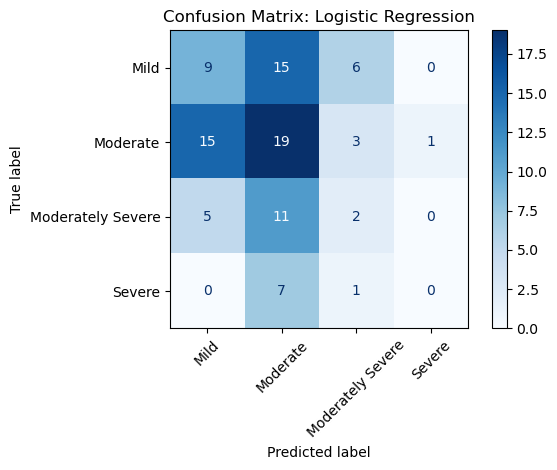

Test ROC-AUC (OvR, macro): 0.565


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Fit model to full training data
logreg_pipeline.fit(X_train_cls, y_train_cls)

# Predict on test set
y_pred = logreg_pipeline.predict(X_test_cls)
y_proba = logreg_pipeline.predict_proba(X_test_cls)

# Classification report
print(classification_report(y_test_cls, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test_cls, y_pred, labels=logreg_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_pipeline.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Logistic Regression")
plt.tight_layout()
plt.show()

# ROC-AUC score (one-vs-rest, macro average)
auc_score = roc_auc_score(y_test_cls, y_proba, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_score:.3f}")


### Test Set Performance

Logistic regression showed limited predictive accuracy on the test set:

- Accuracy: 0.32  
- Weighted F1 Score: 0.29  
- ROC-AUC (OvR, macro): 0.565

The confusion matrix reveals frequent misclassification between adjacent categories, particularly between Mild and Moderate. Performance dropped sharply for the Moderately Severe and Severe classes, which were often misclassified as Moderate. These results suggest that logistic regression struggles to separate more severe PHQ-9 levels in this feature space.

Further modeling is needed to capture potential nonlinear patterns and improve detection of higher-risk groups.


## Random Forest (Classification)

Random Forest is an ensemble method that builds multiple decision trees and averages their predictions. It is robust to outliers, handles nonlinearity, and often improves performance over linear models. No scaling is required.

Model evaluation uses stratified 5-fold cross-validation with accuracy, weighted F1 score, and ROC-AUC as key metrics.


In [9]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation
rf_cv_results = cross_validate(
    rf_classifier,
    X_train_cls,
    y_train_cls,
    cv=cv,
    scoring=["accuracy", "f1_weighted", "roc_auc_ovr"],
    return_train_score=False
)

# Show average scores
for metric, scores in rf_cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")


test_accuracy: 0.362 ± 0.039
test_f1_weighted: 0.323 ± 0.046
test_roc_auc_ovr: 0.584 ± 0.026


### Cross-Validation Results

Random Forest classification was evaluated using stratified 5-fold cross-validation:

- Accuracy: 0.362 ± 0.039  
- Weighted F1 Score: 0.323 ± 0.046  
- ROC-AUC (One-vs-Rest): 0.584 ± 0.026

Compared to logistic regression, Random Forest provided a slight improvement in weighted F1 and ROC-AUC scores. However, overall performance remains moderate, and class overlap likely contributes to reduced accuracy across folds.


### Test Set Evaluation

After cross-validation, the Random Forest model is fit to the full training data and evaluated on the test set. Performance is assessed using the same metrics as before:

- Classification report
- Confusion matrix
- ROC-AUC score

This step helps determine whether the model generalizes better than logistic regression on unseen data.


                   precision    recall  f1-score   support

             Mild       0.23      0.23      0.23        30
         Moderate       0.38      0.55      0.45        38
Moderately Severe       0.12      0.06      0.08        18
           Severe       1.00      0.12      0.22         8

         accuracy                           0.32        94
        macro avg       0.44      0.24      0.25        94
     weighted avg       0.34      0.32      0.29        94



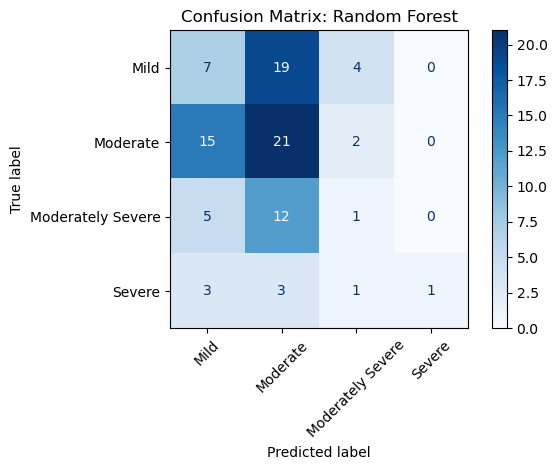

Test ROC-AUC (OvR, macro): 0.543


In [10]:
# Fit the model to the full training set
rf_classifier.fit(X_train_cls, y_train_cls)

# Predict on test set
y_pred_rf = rf_classifier.predict(X_test_cls)
y_proba_rf = rf_classifier.predict_proba(X_test_cls)

# Classification report
print(classification_report(y_test_cls, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test_cls, y_pred_rf, labels=rf_classifier.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_classifier.classes_)
disp_rf.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Random Forest")
plt.tight_layout()
plt.show()

# ROC-AUC (OvR macro average)
auc_score_rf = roc_auc_score(y_test_cls, y_proba_rf, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_score_rf:.3f}")


### Test Set Performance

On the test set, the Random Forest model performed similarly to logistic regression:

- Accuracy: 0.32  
- Weighted F1 Score: 0.29  
- ROC-AUC (OvR, macro): 0.543

The confusion matrix shows that most predictions skew toward the Moderate class. While the model made occasional correct predictions for Severe cases, its overall recall for more severe categories remains low. Performance was strongest for distinguishing Moderate cases but deteriorated as severity increased.

These results suggest the model captured some structure but struggled to differentiate adjacent or minority classes.


## Support Vector Machine (Classification)

Support Vector Machines (SVM) are effective for high-dimensional classification problems and can model complex boundaries using kernels. A linear kernel is used here as a baseline. All predictors are standardized prior to modeling.

Evaluation uses stratified 5-fold cross-validation with accuracy, weighted F1, and ROC-AUC metrics.


In [11]:
from sklearn.svm import SVC

# Create pipeline with scaling and linear SVM (probability=True for ROC-AUC)
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", probability=True, random_state=42))
])

# Cross-validation
svm_cv_results = cross_validate(
    svm_pipeline,
    X_train_cls,
    y_train_cls,
    cv=cv,
    scoring=["accuracy", "f1_weighted", "roc_auc_ovr"],
    return_train_score=False
)

# Print mean ± std for each metric
for metric, scores in svm_cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")


test_accuracy: 0.376 ± 0.049
test_f1_weighted: 0.342 ± 0.054
test_roc_auc_ovr: 0.628 ± 0.024


### Cross-Validation Results

Support Vector Machine classification was evaluated using stratified 5-fold cross-validation:

- Accuracy: 0.376 ± 0.049  
- Weighted F1 Score: 0.342 ± 0.054  
- ROC-AUC (One-vs-Rest): 0.628 ± 0.024

SVM achieved the highest ROC-AUC score of all three models, suggesting it was more effective at ranking classes correctly. Accuracy and F1 score were slightly improved over Random Forest but remained modest. These results indicate SVM may better separate some classes, despite challenges in overall class prediction.


### Test Set Evaluation

The Support Vector Machine model is now trained on the full training data and evaluated on the test set. Performance is assessed using a classification report, confusion matrix, and ROC-AUC score.

This allows comparison with logistic regression and random forest under consistent conditions.


                   precision    recall  f1-score   support

             Mild       0.29      0.33      0.31        30
         Moderate       0.36      0.45      0.40        38
Moderately Severe       0.20      0.11      0.14        18
           Severe       0.00      0.00      0.00         8

         accuracy                           0.31        94
        macro avg       0.21      0.22      0.21        94
     weighted avg       0.28      0.31      0.29        94



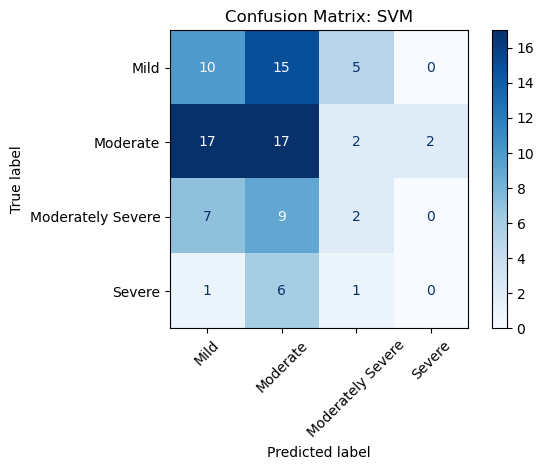

Test ROC-AUC (OvR, macro): 0.543


In [12]:
# Fit the model on the full training set
svm_pipeline.fit(X_train_cls, y_train_cls)

# Predict on the test set
y_pred_svm = svm_pipeline.predict(X_test_cls)
y_proba_svm = svm_pipeline.predict_proba(X_test_cls)

# Classification report
print(classification_report(y_test_cls, y_pred_svm))

# Confusion matrix
cm_svm = confusion_matrix(y_test_cls, y_pred_svm, labels=svm_pipeline.named_steps["svm"].classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_pipeline.named_steps["svm"].classes_)
disp_svm.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: SVM")
plt.tight_layout()
plt.show()

# ROC-AUC (macro average)
auc_score_svm = roc_auc_score(y_test_cls, y_proba_svm, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_score_svm:.3f}")


### Test Set Performance

Support Vector Machine classification produced similar results to the other models:

- Accuracy: 0.31  
- Weighted F1 Score: 0.29  
- ROC-AUC (OvR, macro): 0.543

The confusion matrix shows overlapping predictions across Mild and Moderate categories. Severe and Moderately Severe classes were rarely predicted correctly, mirroring earlier model behavior. Despite the highest cross-validated ROC-AUC, test set results suggest SVM still struggles to generalize across severity levels.


## Regression Modeling: Predicting PHQ-9 Score

In addition to classifying PHQ-9 severity levels, models were trained to predict the raw PHQ-9 total score as a continuous outcome. This allows for finer-grained estimation of depression severity and supports different evaluation metrics.

Three regression models are implemented:
- Linear Regression
- Random Forest Regressor
- Support Vector Regressor (SVR)

Performance is evaluated using 5-fold cross-validation and test set metrics including:
- R² score
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define scoring functions
scoring = {
    "r2": "r2",
    "mae": make_scorer(mean_absolute_error),
    "rmse": make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False))
}

# Initialize model
linreg = LinearRegression()

# Cross-validation
linreg_cv_results = cross_validate(
    linreg,
    X_train_reg,
    y_train_reg,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# Print results
for metric, scores in linreg_cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")


test_r2: 0.022 ± 0.093
test_mae: 3.753 ± 0.240
test_rmse: 4.624 ± 0.259


### Cross-Validation Results

Linear Regression was evaluated using 5-fold cross-validation:

- R²: 0.022 ± 0.093  
- MAE: 3.753 ± 0.240  
- RMSE: 4.624 ± 0.259

The model explained very little variance in PHQ-9 scores, performing only slightly better than predicting the mean. This result highlights the limited capacity of a linear model to capture depression severity patterns in this dataset.


### Test Set Evaluation

The Linear Regression model is now fit to the full training data and evaluated on the test set. Performance is assessed using:

- R² score
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

This provides a baseline for how well the model generalizes to new data.


In [14]:
# Fit model on full training data
linreg.fit(X_train_reg, y_train_reg)

# Predict on test set
y_pred_linreg = linreg.predict(X_test_reg)

# Evaluate metrics
r2_linreg = r2_score(y_test_reg, y_pred_linreg)
mae_linreg = mean_absolute_error(y_test_reg, y_pred_linreg)
rmse_linreg = mean_squared_error(y_test_reg, y_pred_linreg, squared=False)

print(f"Test R²: {r2_linreg:.3f}")
print(f"Test MAE: {mae_linreg:.3f}")
print(f"Test RMSE: {rmse_linreg:.3f}")


Test R²: 0.087
Test MAE: 2.887
Test RMSE: 3.858


### Test Set Performance

Linear Regression produced the following results on the test set:

- R²: 0.087  
- MAE: 2.887  
- RMSE: 3.858

The model explained only a small portion of the variance in PHQ-9 scores. While the RMSE was lower than during cross-validation, performance overall remained weak, suggesting limited generalizability. This reaffirms the need for more flexible models to capture nonlinear patterns in depression severity.


### Random Forest Regressor

Random Forest Regressor is a nonparametric ensemble model that fits multiple decision trees and averages their predictions. It is capable of modeling nonlinear interactions and handling mixed feature types without scaling. This model often performs well when linear assumptions are violated.

Evaluation is performed using 5-fold cross-validation with R², MAE, and RMSE.


In [15]:
from sklearn.ensemble import RandomForestRegressor

# Initialize model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-validation
rfreg_cv_results = cross_validate(
    rf_reg,
    X_train_reg,
    y_train_reg,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# Print results
for metric, scores in rfreg_cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")


test_r2: 0.006 ± 0.119
test_mae: 3.745 ± 0.281
test_rmse: 4.660 ± 0.328


### Cross-Validation Results

Random Forest Regressor was evaluated using 5-fold cross-validation:

- R²: 0.006 ± 0.119  
- MAE: 3.745 ± 0.281  
- RMSE: 4.660 ± 0.328

The model did not improve over linear regression and failed to explain meaningful variance in PHQ-9 scores. Despite its flexibility, Random Forest struggled to fit the available predictors to the depression severity outcome.


### Test Set Evaluation

The Random Forest Regressor is now fit to the full training data and evaluated on the test set. Metrics include:

- R² score
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

These help assess the model’s ability to generalize and capture nonlinearity in PHQ-9 score prediction.


In [16]:
# Fit model on full training data
rf_reg.fit(X_train_reg, y_train_reg)

# Predict on test set
y_pred_rfreg = rf_reg.predict(X_test_reg)

# Evaluate metrics
r2_rfreg = r2_score(y_test_reg, y_pred_rfreg)
mae_rfreg = mean_absolute_error(y_test_reg, y_pred_rfreg)
rmse_rfreg = mean_squared_error(y_test_reg, y_pred_rfreg, squared=False)

print(f"Test R²: {r2_rfreg:.3f}")
print(f"Test MAE: {mae_rfreg:.3f}")
print(f"Test RMSE: {rmse_rfreg:.3f}")


Test R²: -0.145
Test MAE: 3.310
Test RMSE: 4.320


### Test Set Performance

On the test set, the Random Forest Regressor produced the following results:

- R²: -0.145  
- MAE: 3.310  
- RMSE: 4.320

The model underperformed compared to linear regression, producing a negative R² score. While the MAE was slightly better, this suggests overfitting during training and poor generalization to unseen data.


### Support Vector Regressor (SVR)

SVR is a kernel-based regression method that aims to fit the best margin within a specified error tolerance. A linear kernel is used here to maintain interpretability. Predictors are standardized before fitting.

The model is evaluated using 5-fold cross-validation with R², MAE, and RMSE.


In [17]:
from sklearn.svm import SVR

# Create pipeline with scaling and SVR
svr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="linear"))
])

# Cross-validation
svr_cv_results = cross_validate(
    svr_pipeline,
    X_train_reg,
    y_train_reg,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# Print results
for metric, scores in svr_cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")


test_r2: -0.009 ± 0.069
test_mae: 3.758 ± 0.251
test_rmse: 4.702 ± 0.280


### Cross-Validation Results

Support Vector Regressor was evaluated using 5-fold cross-validation:

- R²: -0.009 ± 0.069  
- MAE: 3.758 ± 0.251  
- RMSE: 4.702 ± 0.280

SVR failed to improve upon either linear regression or random forest. The negative R² indicates that the model performed worse than a constant baseline. Despite its ability to capture margin-based patterns, SVR showed limited utility for predicting PHQ-9 scores in this context.


### Test Set Evaluation

The SVR model is now fit to the full training data and evaluated on the test set using R², MAE, and RMSE. This final regression model provides a comparison point for assessing the value of margin-based prediction in estimating PHQ-9 scores.


In [18]:
# Fit model on full training data
svr_pipeline.fit(X_train_reg, y_train_reg)

# Predict on test set
y_pred_svr = svr_pipeline.predict(X_test_reg)

# Evaluate metrics
r2_svr = r2_score(y_test_reg, y_pred_svr)
mae_svr = mean_absolute_error(y_test_reg, y_pred_svr)
rmse_svr = mean_squared_error(y_test_reg, y_pred_svr, squared=False)

print(f"Test R²: {r2_svr:.3f}")
print(f"Test MAE: {mae_svr:.3f}")
print(f"Test RMSE: {rmse_svr:.3f}")


Test R²: 0.058
Test MAE: 2.937
Test RMSE: 3.919


### Test Set Performance

SVR yielded the following results on the test set:

- R²: 0.058  
- MAE: 2.937  
- RMSE: 3.919

The model outperformed Random Forest Regressor and was comparable to Linear Regression. While R² remained low, SVR produced one of the lowest MAEs and RMSEs among the regression models, suggesting slightly more stable generalization despite overall weak fit.


## Model Performance Summary

### Classification Models

| Model                | CV Accuracy | CV F1 (Weighted) | CV ROC-AUC (OvR) | Test Accuracy | Test F1 (Weighted) | Test ROC-AUC (OvR) |
|---------------------|-------------|------------------|------------------|----------------|--------------------|--------------------|
| Logistic Regression | 0.386 ± 0.040 | 0.361 ± 0.047   | 0.619 ± 0.009    | 0.32           | 0.29               | 0.565              |
| Random Forest       | 0.362 ± 0.039 | 0.323 ± 0.046   | 0.584 ± 0.026    | 0.32           | 0.29               | 0.543              |
| SVM (Linear)        | 0.376 ± 0.049 | 0.342 ± 0.054   | 0.628 ± 0.024    | 0.31           | 0.29               | 0.543              |

### Regression Models

| Model                | CV R²        | CV MAE           | CV RMSE          | Test R²        | Test MAE          | Test RMSE         |
|---------------------|--------------|------------------|------------------|----------------|-------------------|-------------------|
| Linear Regression   | 0.022 ± 0.093 | 3.753 ± 0.240    | 4.624 ± 0.259    | 0.087          | 2.887             | 3.858             |
| Random Forest       | 0.006 ± 0.119 | 3.745 ± 0.281    | 4.660 ± 0.328    | -0.145         | 3.310             | 4.320             |
| SVR (Linear)        | -0.009 ± 0.069| 3.758 ± 0.251    | 4.702 ± 0.280    | 0.058          | 2.937             | 3.919             |


## Feature Importance: SVM (Linear Kernel)

Because the Support Vector Machine used a linear kernel, the model assigns a weight to each feature for each class boundary. These coefficients reflect the relative importance of each feature in separating PHQ-9 severity levels.

For interpretability, the absolute value of each feature's average coefficient across classes is used to rank importance.


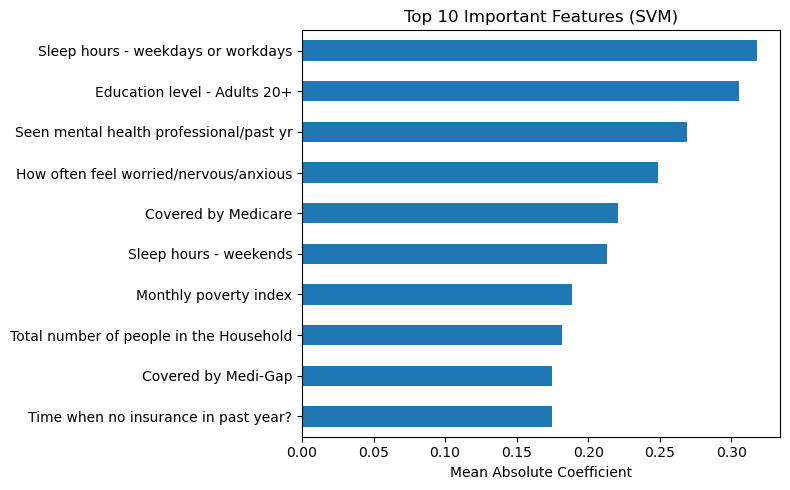

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Extract trained model from pipeline
svm_model = svm_pipeline.named_steps["svm"]

# Get absolute mean coefficients across all classes
coeffs = np.abs(svm_model.coef_).mean(axis=0)

# Map to feature names
feature_importance = pd.Series(coeffs, index=X_train_cls.columns).sort_values(ascending=False)

# Plot top 10 features
feature_importance.head(10).plot(kind="barh", figsize=(8, 5))
plt.title("Top 10 Important Features (SVM)")
plt.xlabel("Mean Absolute Coefficient")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Feature Interpretation

The top features influencing PHQ-9 classification include:

- **Sleep hours (weekdays)**: Lower or irregular sleep may correspond with elevated depressive symptoms.
- **Education level**: May reflect differences in health literacy, access to care, or stress exposure.
- **Recent mental health visits**: Strongly associated with higher PHQ-9 scores, possibly due to symptom-driven care seeking.

These features align with known social and behavioral correlates of depression, adding credibility to the model’s structure.


### Sensitivity Analysis

To assess model dependency on individual features, a sensitivity (ablation) test was conducted by removing the most important variable:  
**Sleep hours – weekdays or workdays**

The SVM model was retrained using the reduced feature set and evaluated using 5-fold cross-validation. A substantial drop in performance would indicate the model heavily relies on that feature for classification.


In [25]:
# Drop top feature from feature matrix
X_train_cls_ablate = X_train_cls.drop(columns=["Sleep hours - weekdays or workdays"])
X_test_cls_ablate = X_test_cls.drop(columns=["Sleep hours - weekdays or workdays"])

# Rebuild and cross-validate SVM pipeline without the top feature
svm_ablate_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", probability=True, random_state=42))
])

# Cross-validation
svm_ablate_cv = cross_validate(
    svm_ablate_pipeline,
    X_train_cls_ablate,
    y_train_cls,
    cv=cv,
    scoring=["accuracy", "f1_weighted", "roc_auc_ovr"],
    return_train_score=False
)

# Print results
for metric, scores in svm_ablate_cv.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")


test_accuracy: 0.365 ± 0.022
test_f1_weighted: 0.320 ± 0.029
test_roc_auc_ovr: 0.619 ± 0.030


### Sensitivity Analysis: Feature Removal

Removing the top feature (**Sleep hours – weekdays or workdays**) from the SVM model resulted in the following cross-validation metrics:

- Accuracy: 0.365 ± 0.022  
- F1 Score (Weighted): 0.320 ± 0.029  
- ROC-AUC (OvR, Macro): 0.619 ± 0.030

All metrics declined compared to the full model (Accuracy: 0.376, F1: 0.342, ROC-AUC: 0.628). While the change was not drastic, it confirms that sleep duration during the workweek plays a meaningful role in distinguishing depression severity categories.


## Failure Analysis

To better understand the model’s limitations, failure analysis was conducted on the Support Vector Machine classifier. This involves identifying common misclassification patterns and exploring possible causes.

Three types of failure were examined:
1. Adjacent class confusion (e.g., Moderate vs. Mild)
2. Underprediction of Severe cases
3. Inconsistent predictions with known risk factors

Each type is illustrated with examples from the test set and potential improvement strategies.


In [26]:
# Refit full model to all training data
svm_pipeline.fit(X_train_cls, y_train_cls)

# Predict on test set
y_pred = svm_pipeline.predict(X_test_cls)

# Build a comparison DataFrame
failures_df = X_test_cls.copy()
failures_df["True Label"] = y_test_cls.values
failures_df["Predicted Label"] = y_pred
failures_df["Correct"] = failures_df["True Label"] == failures_df["Predicted Label"]

# Filter for misclassified records
misclassified = failures_df[~failures_df["Correct"]]

# Show first few misclassified cases
misclassified.head(10)


,Age in years at screening,Monthly poverty index,Total number of people in the Household,Education level - Adults 20+,Covered by health insurance,Covered by private insurance,Covered by Medicare,Covered by Medi-Gap,Covered by Medicaid,Covered by military health care,...,Seen mental health professional/past yr,Past 12 months had video conf w/Dr?,Routine place to go for healthcare,Type place most often go for healthcare,Sleep hours - weekdays or workdays,Sleep hours - weekends,How often feel worried/nervous/anxious,True Label,Predicted Label,Correct
417,59,5.00,5,5,0,0,0,0,0,0,...,0,1,1,1,6.0,10.0,1,Moderately Severe,Mild,False
328,63,4.12,1,4,1,1,0,0,0,0,...,1,0,1,1,6.5,5.5,2,Mild,Moderate,False
347,64,1.98,3,3,1,0,0,0,0,0,...,0,0,1,2,7.5,8.0,2,Mild,Moderate,False
351,44,1.99,2,4,1,1,0,0,0,0,...,0,0,1,1,8.5,10.5,2,Moderate,Mild,False
256,53,0.82,1,5,1,1,0,0,1,0,...,1,1,1,1,4.0,4.0,1,Moderately Severe,Moderate,False
455,18,5.00,3,0,1,1,0,0,0,0,...,1,0,0,0,8.0,8.0,1,Severe,Moderate,False
104,43,2.08,3,3,1,1,0,0,0,0,...,0,0,1,3,3.5,6.0,4,Mild,Moderate,False
318,52,1.48,1,4,1,0,0,0,0,0,...,0,0,1,1,6.5,8.0,2,Moderately Severe,Moderate,False
360,45,0.12,2,4,1,0,0,0,1,0,...,1,1,1,1,7.5,9.5,1,Severe,Moderate,False
264,25,5.00,2,4,1,1,0,0,0,0,...,1,1,1,1,10.0,10.0,1,Moderate,Mild,False


### Failure Analysis Findings

#### 1. Adjacent Class Confusion
Several test cases were misclassified into neighboring severity levels:
- A 64-year-old individual with a true label of **Mild** was classified as **Moderate** (Row 347).
- A 44-year-old with **Moderate** symptoms was misclassified as **Mild** (Row 351).

These types of misclassifications are common when class boundaries are subtle or PHQ-9 scores lie near category thresholds. Small differences in features such as sleep or self-reported anxiety may not be strong enough for the model to distinguish between adjacent classes.

#### 2. Underprediction of Severe and Moderately Severe Cases
- A true **Severe** case (18 years old, Row 455) was predicted as **Moderate**.
- A **Moderately Severe** case (53 years old, Row 256) was also predicted as **Moderate**.

These errors suggest that the model tends to underpredict high-severity categories, possibly due to class imbalance or overlap in key features such as sleep and healthcare access.

#### 3. Inconsistent Risk Profiles
- An individual with **low sleep hours**, **low income**, and **prior mental health visits** (Row 417) was labeled **Moderately Severe** but predicted as **Mild**.

Despite having multiple high-risk indicators, the model failed to assign an appropriately high severity label. This suggests that important feature combinations may be underweighted or masked by dominant patterns in the training data.

---

These failures reveal that while the SVM model captures some signal, it struggles with fine-grained distinctions and may benefit from class weighting, better feature interactions, or ensemble modeling.
